# imports


In [9]:
import sys 
sys.path.append("/s3/scratch/wessim.omezzine/ClimaX/hip-analysis")
sys.path.append("/s3/scratch/wessim.omezzine/ClimaX/")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime



import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import rasterio

import warnings
warnings.filterwarnings("ignore")

import s3fs
import xarray as xr
import dask
# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

        
client = Client()
client

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43653
INFO:distributed.scheduler:  dashboard at:  /user-redirect/proxy/8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45371'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46857'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40269'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39775'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42331', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42331
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:41404
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:34065', name: 1, 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user-redirect/proxy/8787/status,
Dashboard: /user-redirect/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43653,Workers: 4
Dashboard: /user-redirect/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.20 GiB
Comm: tcp://127.0.0.1:42331,Total threads: 1
Dashboard: /user-redirect/proxy/43123/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:45371,


# Introduction

This notebook is dor data preparation for ClimaX and other Downscaling methods

# Data Preparation

We will take the example of a region in Mozambique. For the sake of having clear date and non-sparse, we will only the rain season of the region. In the cas eof mozambique, <div style="color: blue; text-align: center; font-size: 24px;">Rainy Season in Mozambique: October to March</div>


In [10]:
region = "Mozambique/Members/region_1"
start_season = 10
end_season = 3

bbox = (
    28.223877,
    -24.966140,
    34.178467,
    -19.859727,
)  # (-30.259067,17.951660,-18.895893,35.573730)

area = AnalysisArea(
    bbox=bbox, datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983
)

## ECMWF Forecasts: Charge & put them in aggregated dekadal data

ECMWF depends of the `the issue month`  refers to the month when the forecast data was released or generated. In our case we generate the future 6 months

The data is organized in these dimensions (time, ensemble, latitude, longitude). Every member refers to a new initial condition to use the numerical model.

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/09/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2]))

In [ ]:
ds_issue = ds_issue.tp.load()

da_issue= ds_issue.groupby("time.year").apply(lambda da :  da.diff(dim='time', n=1))
# da_issue = da_issue.mean("ensemble") #Output 1 ensemble
# #da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
da_issue.to_netcdf(f'Data/Downscaling/Rainfall/{region}/da_issue.nc')

In [29]:
da_issue = xr.open_dataarray(f'Data/Downscaling/Rainfall/{region}/da_issue.nc')

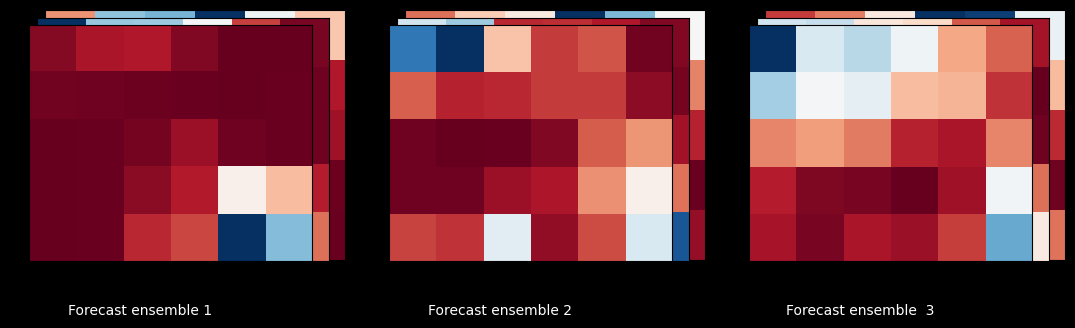

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'r1h' is an xarray DataArray with dimensions [time, band]
# and contains the data for plotting

# Define the initial position and size for the first plot in each column
initial_position = [0.05, 0.1, 0.25, 0.8]
horizontal_shift = 0.3  # Space between the columns

# Create a figure with a black background
fig = plt.figure(figsize=(12, 4), facecolor='black')
Data  = [da_issue.isel(ensemble=0), da_issue.isel(ensemble=1), da_issue.isel(ensemble=2)]
# Text for each column
column_text = ['Forecast ensemble 1', 'Forecast ensemble 2', 'Forecast ensemble  3']
# Loop to create three columns
for col in range(3):
    # Reset the position for the new column
    position = initial_position.copy()
    position[0] += col * horizontal_shift  # Shift the column to the right

    # Extract data for the current column (assuming 'band' is the second dimension)
    data = Data[col].isel(time=slice(0, 3)).values

    # Loop over the data to create each layered plot
    for i, data_matrix in enumerate(data):
        # Create an axis object for the current plot
        ax = fig.add_axes(position, zorder=i, facecolor='black')
        
        # Display the data
        ax.imshow(data_matrix, cmap=plt.cm.RdBu, interpolation='nearest')
        
        # Modify the position for the next plot within the same column
        position[0] -= 0.007
        position[1] -= 0.007  # Shift up
        position[2] -= 0.007  # Reduce width
        position[3] -= 0.007 # Reduce height
        
         # Add text below each column
    fig.text(position[0] + 0.1, 0.05, column_text[col], ha='center', color='white')


# Show the plot
plt.show()


In [ ]:
crs = ds_issue.rio.crs

# Define the path to the output file
output_file = "crs.wkt"

# Save the CRS to the output file in WKT format
with open(output_file, "w") as file:
    file.write(crs.to_wkt())

In [ ]:
import rasterio

# Define the path to the WKT file containing the CRS information
wkt_file = "crs.wkt"

# Read the CRS from the WKT file
with open(wkt_file, "r") as file:
    wkt = file.read()
    crs = rasterio.crs.CRS.from_string(wkt)

We aggregate the data on dekads

In [ ]:
da_issue= da_issue.sel(time=slice(r1h['time'].min().values, r1h['time'].max().values))

# DONT RUN only for dekad!!!!!
from hdc.algo.accessors import Dekad
from odc import stac
import datetime

def dekad_to_date(dekad):
    dek = str(dekad)
    DEKAD = {'1':1,'2':11,'3':21}
    
    return np.datetime64(datetime.date(int(dek[:4]), int(dek[4:6]), DEKAD[dek[-1]]))



da_issue_dek = da_issue.sel(time=(da_issue['time.month'] >= start_season) | (da_issue['time.month'] <= end_season))

    
    
# da_issue_dek = da_issue_dek.where(da_issue_dek.time.dt.month.isin(range(start_season, end_season)), drop=True)
da_issue_dek = da_issue_dek.assign_coords(dek=Dekad(da_issue_dek.time).label)
da_issue_dek = da_issue_dek.groupby(da_issue_dek.dek).sum()

time = [dekad_to_date(dekad.values) for dekad in da_issue_dek.dek]
da_issue_dek['dek'] = time

da_issue  =da_issue_dek.rename(dek='time')


and then we put them in the shape `[time*ensemble, latitude, longitude]` and we select only 20 members with the parameter `rep` 

In [ ]:
rep=20

In [ ]:
# Members not in one block
import numpy as np
import xarray as xr



tp = np.random.rand(da_issue.time.shape[0] * rep, da_issue.latitude.values.shape[0], da_issue.longitude.values.shape[0])

for member in range(rep):
    for t in  range(da_issue.time.shape[0]):
        tp[member*da_issue.time.shape[0]+t] = da_issue.isel(time = t, ensemble=member).tp.values
        

# Create an Xarray DataArray
new_da = xr.DataArray(tp, coords={'time': np.arange(da_issue.time.shape[0] * rep),
                                  'latitude': np.arange( da_issue.latitude.values.shape[0]),
                                  'longitude': np.arange( da_issue.longitude.values.shape[0])},
                      dims=['time', 'latitude', 'longitude'],
                      name='tp')

new_da['time'] = np.tile(r1h.time.values,rep)
new_da['latitude'] = da_issue['latitude']
new_da['longitude'] = da_issue['longitude']


In [ ]:
window_size = 3  # Number of previous dates to include in the sum
da_issue_agg = new_da.rolling(time=window_size, min_periods=window_size).sum()
# da_issue_agg = da_issue.isel(time=slice(window_size - 1, None))
da_issue_agg =  da_issue_agg.combine_first(new_da)
new_da_agg = da_issue_agg

In [ ]:
# da_monthly_sum = da_issue.resample(time='1M').sum()
# da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = new_da_agg.rio.write_crs(crs).rio.reproject(r1h.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})


In [ ]:
da_monthly_sum_season_near.to_netcdf(f"Data/Downscaling/Rainfall/{region}/da_monthly_sum_season_near.nc") 

In [48]:
da_monthly_sum_season_near = xr.open_dataset(f"Data/Downscaling/Rainfall/{region}/da_monthly_sum_season_near.nc")

In [49]:
da_monthly_sum_season_near

<xarray.Dataset>
Dimensions:      (longitude: 120, latitude: 100, time: 14580)
Coordinates:
  * longitude    (longitude) float64 28.02 28.07 28.12 ... 33.88 33.92 33.98
  * latitude     (latitude) float64 -20.02 -20.07 -20.12 ... -24.92 -24.97
  * time         (time) datetime64[ns] 1983-01-01 1983-01-11 ... 2023-03-21
Data variables:
    spatial_ref  int64 ...
    tp           (time, latitude, longitude) float64 ...

## CHIRPS DATA 

In order to have more information, we use an aggregation of Rainfall data over one month(**The product R1H**) 

In [17]:
r1h = area.get_dataset(["CHIRPS","r1h_dekad"])
r1h = r1h.load()
r1h = r1h.sel(time=(r1h['time.month'] >= start_season) | (r1h['time.month'] <= end_season))
r1h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/r1h.nc')

In [12]:
r1h = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/r1h.nc')
r1h = r1h.sel(time=(r1h['time.month'] >= start_season) | (r1h['time.month'] <= end_season))

In [13]:
r1h

<xarray.Dataset>
Dimensions:      (latitude: 103, longitude: 120, time: 729)
Coordinates:
  * latitude     (latitude) float64 -19.88 -19.93 -19.98 ... -24.93 -24.98
  * longitude    (longitude) float64 28.23 28.28 28.33 ... 34.08 34.12 34.18
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 1983-01-01 1983-01-11 ... 2023-03-21
Data variables:
    band         (time, latitude, longitude) float64 ...

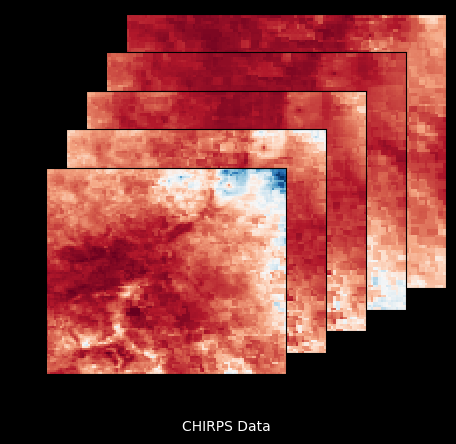

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `data` is a list of arrays representing the data for each plot.
data = r1h.isel(time=slice(0,5)).band.values
# Set up the figure
fig = plt.figure(figsize=(4,4),facecolor='black')

# The initial position for the first plot
initial_position = [0.1, 0.1, 0.8, 0.8]

# Loop over your data to create each layered plot
for i, data_matrix in enumerate(data):
    # Create an axis object for the current plot
    ax = fig.add_axes(initial_position, zorder=i, facecolor='black')
    
    # Display the data
    ax.imshow(data_matrix, cmap=plt.cm.RdBu, interpolation='nearest')
    
    # Modify the position for the next plot (x and y position, width and height)
    initial_position = [x - 0.05 for x in initial_position]
    

    
fig.text(initial_position [0] + 0.5 , -0.2, "CHIRPS Data", ha='center', color='white')

# Show the plot
plt.show()


We need to repeat the CHIRPS data `ensemble` times. Then each member have a correponding chirps data. 

In [67]:
band = np.random.rand(r1h.time.values.shape[0]*rep, r1h.latitude.values.shape[0], r1h.longitude.values.shape[0])

# Create an Xarray DataArray
new_r1h = xr.DataArray(band, coords={'time': np.arange(r1h.time.values.shape[0]*rep),
                               'latitude': np.arange(r1h.latitude.values.shape[0]),
                               'longitude': np.arange(r1h.longitude.values.shape[0])},
                    dims=['time', 'latitude', 'longitude'],
                    name='band')

# new_r1h.values =  np.repeat(r1h.values, rep, axis=0)
new_r1h.values =  np.tile(r1h.band.values, (rep, 1,1))

new_r1h['time'] =  np.tile(r1h.time.values,rep)
new_r1h['latitude'] = r1h['latitude']
new_r1h['longitude'] = r1h['longitude']


In [ ]:
new_r1h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/new_r1h.nc')

In [69]:
new_r1h = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/new_r1h.nc')

## Reproject the two datasets and select RIO 

In [ ]:
r1h_resample = new_r1h.sel(latitude = slice(da_monthly_sum_season_near.latitude[0].values, da_monthly_sum_season_near.latitude[-1].values ), longitude = slice(da_monthly_sum_season_near.longitude[0].values, da_monthly_sum_season_near.longitude[-1].values))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = r1h_resample.latitude.values, longitude= r1h_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

In [ ]:
da_monthly_sum_season_near = da_monthly_sum_season_near.sel(time=(da_monthly_sum_season_near['time.month'] >= start_season) | (da_monthly_sum_season_near['time.month'] <= end_season))


In [13]:
from itertools import product
latitude_starts = [0]
longitude_starts = [0]
region_counter = 10
for start_lat, start_lon in product(latitude_starts, longitude_starts):
    
    new_r1h = r1h_resample.isel(latitude=slice(start_lat,start_lat + latitude_size), longitude=slice(start_lon, start_lon+64))
    da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(start_lat,start_lat + latitude_size), longitude=slice(start_lon, start_lon+64))
    scaling_factors = 1e3
    forecast = da_monthly_sum_season_near*scaling_factors
    
    folderpath = f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{region_counter}/data/'
    
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)
    
    
    forecast.to_netcdf(folderpath+'forecast.nc')
    new_r1h.to_netcdf(folderpath+'r1h.nc')
    region_counter+=1

In [93]:
from itertools import product
latitude_starts = [0, 32, 64]
longitude_starts = [0, 32, 64]
region_counter = 1 
for start_lat, start_lon in product(latitude_starts, longitude_starts):
    
    new_r1h = r1h_resample.isel(latitude=slice(start_lat,start_lat + latitude_size), longitude=slice(start_lon, start_lon+longitude_size))
    da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(start_lat,start_lat + latitude_size), longitude=slice(start_lon, start_lon+longitude_size))
    scaling_factors = 1e3
    forecast = da_monthly_sum_season_near*scaling_factors
    
    folderpath = f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{region_counter}/data/'
    
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)
    
    
    forecast.to_netcdf(folderpath+'forecast.nc')
    new_r1h.to_netcdf(folderpath+'r1h.nc')
    region_counter+=1

## LTA

In [96]:
for region_counter in range(1,10):
    
    folderpath = f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{region_counter}/data/'
    
    forecast_near = xr.open_dataset(folderpath + 'forecast.nc')
    # forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
    r1h_read = xr.open_dataset(folderpath + 'r1h.nc').isel(time=slice(0,r1h.time.values.shape[0]))



    rfh_lta = r1h_read.sel(time=slice("1983-02-28","2018-05-31"))
    rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
    rfh_lta = rfh_lta.sel(strftime=r1h.time.dt.strftime("%m-%d"))


    band = np.random.rand(r1h.time.values.shape[0]*rep, 32, 32)

    # Create an Xarray DataArray
    new_r1h_lta = xr.DataArray(band, coords={'time': np.arange(r1h.time.values.shape[0]*rep),
                                   'latitude': np.arange(32),
                                   'longitude': np.arange(32)},
                        dims=['time', 'latitude', 'longitude'],
                        name='band')

    # new_r1h.values =  np.repeat(r1h.values, rep, axis=0)
    new_r1h_lta.values =  np.tile(rfh_lta.band.values, (rep, 1,1))

    new_r1h_lta['time'] =  np.tile(r1h.time.values,rep)
    new_r1h_lta['latitude'] = r1h_read['latitude']
    new_r1h_lta['longitude'] = r1h_read['longitude']

    new_r1h_lta.to_netcdf(folderpath + 'r1h_lta.nc')

    

In [15]:
for region_counter in range(10,11):
    
    folderpath = f'Data/Downscaling/Rainfall/Mozambique/Regions/region_{region_counter}/data/'
    
    forecast_near = xr.open_dataset(folderpath + 'forecast.nc')
    # forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
    r1h_read = xr.open_dataset(folderpath + 'r1h.nc').isel(time=slice(0,r1h.time.values.shape[0]))



    rfh_lta = r1h_read.sel(time=slice("1983-02-28","2018-05-31"))
    rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
    rfh_lta = rfh_lta.sel(strftime=r1h.time.dt.strftime("%m-%d"))


    band = np.random.rand(r1h.time.values.shape[0]*rep, 32, 64)

    # Create an Xarray DataArray
    new_r1h_lta = xr.DataArray(band, coords={'time': np.arange(r1h.time.values.shape[0]*rep),
                                   'latitude': np.arange(32),
                                   'longitude': np.arange(64)},
                        dims=['time', 'latitude', 'longitude'],
                        name='band')

    # new_r1h.values =  np.repeat(r1h.values, rep, axis=0)
    new_r1h_lta.values =  np.tile(rfh_lta.band.values, (rep, 1,1))

    new_r1h_lta['time'] =  np.tile(r1h.time.values,rep)
    new_r1h_lta['latitude'] = r1h_read['latitude']
    new_r1h_lta['longitude'] = r1h_read['longitude']

    new_r1h_lta.to_netcdf(folderpath + 'r1h_lta.nc')

    

Until this step we get this organization of the folder 

./region

|__ data

|____ forecast.nc

|____ r1h.nc

|____ r1h_lta.nc

# Preprocessing

We want to preprocess the data to get the normalization of each variable, we seperate the data in differnet years and segregate them in_variables and out_variables by executing this command

In [ ]:
! src/data_preprocessing/nc2np_equally_ecmwf_downscaling.py --region="Mozambique/Regions/region_1"